In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

countries = CountryMetaDataFile().readMetadata()
dl = DataLib("SignalData")

In [14]:
# Setting up Bond Return Index variables
BondReturnIndex = dl.pull('BondRetIdx/LocalFX') # daily, represents accumulated returns from holding 10-year bonds
average = 'Equal Weighted Mean'
BondReturnIndex[average] = BondReturnIndex.mean(axis=1) # global average
MonthlyBondReturnIndex = BondReturnIndex.resample('1M').mean()
MonthlyBondReturnIndex[average] = MonthlyBondReturnIndex.mean(axis=1) # global average

# Indicator 1: Bond Premium

* What it is: difference between the long rate and short rate
* What it means: reflects the slope of the yield curve
* What it tells us: the greater the bond premium, the greater the spread between long and short rates
* What we expect: typically the bond premium is positive (meaning that long rates > short rates) since there is more risk associated with holding bonds for longer
* What this tells us about bonds: steepening yield curves attracts investors with long positions

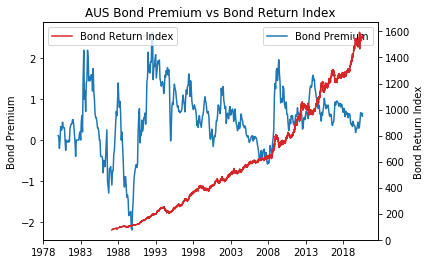

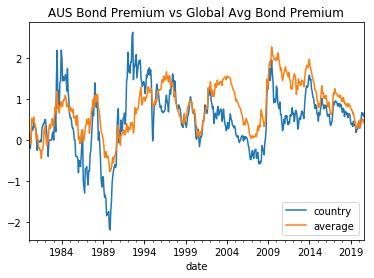

In [124]:
# Calculating Bond Premium for all countries
ShortRates = dl.pull('ShortRates') # monthly
LongRates = dl.pull('LongRates') # monthly, nominal yield on 10-year govenment issued bonds
BondPremium = LongRates - ShortRates
BondPremium[average] = BondPremium.mean(axis=1) # global average

country = 'AUS'

# Bond Premium vs. Bond Returns
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Bond Premium'
ax1.plot(BondPremium[country].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Bond Return Index'
ax2.plot(BondReturnIndex[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} Bond Premium vs Bond Return Index')
plt.show()

# Bond Premium vs. Global Avg Bond Premium
BondPremium[country].plot()
BondPremium[average].plot()
plt.legend(['country', 'average'])
plt.title(f'{country} Bond Premium vs Global Avg Bond Premium')
plt.show()

In [125]:
# Calculate and display P&L values from prediction dataframe
def PnLAnalysis(data, country):
    
    # Calculate P&L
    data['pnlA'] = data['PredictionA'] * data[country].shift(1).pct_change()
    data['pnlB'] = data['PredictionB'] * data[country].shift(1).pct_change()
    
    # Plot P&L Curves
    data['pnlA'].cumsum().plot()
    data['pnlB'].cumsum().plot()
    plt.title(f'{country} P&L Curves')
    plt.show()
    
    return data

# LOGIC
* The bigger the Bond Premium, the steeper the yield curve, the bigger our long position
* If the Bond Premium is relatively bigger, our position should be positive (long)
* Curve is steepening if premium at given day is greater than some rolling average
* We can scale our Bond Premium by whether or not it is steepening before standardizing

In [126]:
# Takes in a country and returns prediction dataframe
def BondPremiumIndicator(country):
    
    # Set up monthly country data
    data = pd.DataFrame(MonthlyBondReturnIndex[country])
    data['BondPremium'] = BondPremium[country]
    
    # Prediction A: Prediction scaled by domestic change in BP over 6-month period
    # Standardize this month's BP relative to past BP within country withing 6M window
    data['PredictionA'] = (data['BondPremium'] - data['BondPremium'].rolling(6).mean()) / data['BondPremium'].rolling(6).std() 
    
    ## This is how I am getting my predictions into the [-1,1] range
    data['NormalizedA'] = (data['PredictionA'] - data['PredictionA'].rolling(24).min()) / (data['PredictionA'].rolling(6).max()-data['PredictionA'].rolling(24).min())*2-1
    
    # Prediction B: Prediction scaled by global average
    # Standardize this month's BP relative to past BP global average withing 6M window
    data['GlobalAvg'] = BondPremium[average]
    data['PredictionB'] = (data['BondPremium'] - data['GlobalAvg'].rolling(6).mean()) / data['GlobalAvg'].rolling(6).std() 

    # Calculate P&L
    data = PnLAnalysis(data, country)

    return data

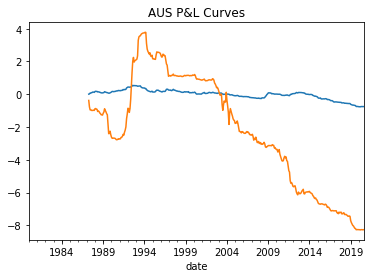

                 AUS  BondPremium  PredictionA  NormalizedA  GlobalAvg  \
date                                                                     
1980-01          NaN        0.110          NaN          NaN    0.18500   
1980-02          NaN        0.070          NaN          NaN    0.06225   
1980-03          NaN       -0.200          NaN          NaN   -0.09450   
1980-04          NaN        0.000          NaN          NaN   -0.02875   
1980-05          NaN        0.330          NaN          NaN    0.52850   
1980-06          NaN        0.240     0.797253          NaN    0.42300   
1980-07          NaN        0.260     0.721493          NaN    0.46575   
1980-08          NaN        0.440     1.111949          NaN    0.56100   
1980-09          NaN        0.320     0.372935          NaN    0.43025   
1980-10          NaN        0.300    -0.213201          NaN    0.36750   
1980-11          NaN        0.300    -0.142566          NaN    0.18425   
1980-12          NaN        0.000    -

In [127]:
results = BondPremiumIndicator('AUS')
print(results)